In [18]:
# Add .. to sys.path
import sys
sys.path.append('..')


## Exploration

https://medium.com/analytics-vidhya/airbnb-data-exploration-analysis-and-feature-engineering-edbb47bf115

## Imputation strategies

Imputation is the process of filling in missing values in a dataset. Here are some common imputation strategies for machine learning:

1. Mean/Median/Mode imputation: Replace missing values with the mean, median or mode of the non-missing values in the same column.

2. Regression imputation: Use a regression model to predict missing values based on other features in the dataset.

3. K-Nearest Neighbors (KNN) imputation: Find the K nearest neighbors to the observation with missing values and use their values to impute the missing value.

4. Multiple Imputation by Chained Equations (MICE): MICE is an iterative imputation method that imputes missing values multiple times using a regression model and combines the results to create a final imputed dataset.

5. Random Forest imputation: Use a random forest model to predict missing values based on other features in the dataset.

6. Deep Learning imputation: Use a deep learning model to predict missing values based on other features in the dataset.

The choice of imputation strategy depends on the nature of the missing data and the specific requirements of the machine learning problem. It is important to carefully consider the implications of each imputation strategy and evaluate the performance of the resulting model.

## TODOs and options

- feature eng
- feature scaling
- target transform

## Baselines

- sklearn.dummy.DummyClassifier
- sklearn.dummy.DummyRegressor

## Causal Graph

Note:  
replaced `from collections import Iterable` with `from collections.abc import Iterable` in `~/anaconda3/envs/cheatsheet/lib/python3.10/site-packages/causalgraphicalmodels/cgm.py` because of python 3.10.

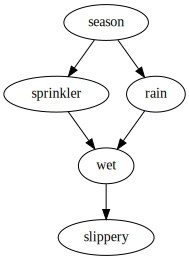

In [3]:
from causalgraphicalmodels import CausalGraphicalModel
sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

https://github.com/ijmbarr/causalgraphicalmodels/blob/master/notebooks/cgm-examples.ipynb

https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266

## Statistical tests

Regression:

- Normality test (or shapiro)
   from scipy.stats import normaltest   
   The null hypothesis of the test (H0), or the default expectation, is that the statistic describes a normal distribution.   
      
- T test homoelasticity
   value, pvalue = ttest_ind(values1, values2, equal_var=True)  
   The null hypothesis of the test (H0) or the default expectation is that both samples were drawn from the same population
- T test heteroelasticity  
    value, pvalue = ttest_ind(values1, values2, equal_var=False)  
- Compare means for non-gaussian distributions: Kolmogorov-Smirnov
    from scipy.stats import ks_2samp  
    This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.  
    less statistical power and may require large samples  
- Compare means for non-gaussian with small samples: Mann-Whitney / Wilcoxon
    from scipy.stats import mannwhitneyu



Binary classification:
- from scipy.stats import chi2_contingency
    stat, p_value = chi2_contingency(table, correction=False)  
    pd.crosstab()

Chi2 test:
- determine whether there is a significant association between two cateorical variables
- stat, p_value, dof, expected = chi2_contingency(table)


ANOVA
- from scipy.stats import f_oneway
-  null hypothesis no significant difference between means of samples
- assumes normality and equal variances
- use kruskal-wallis test if hypothesis broken: from scipy.stats import kruskal (non-parametric on median)

## SHAP Values

SHAP is about local interpretability of a predictive model

- the “game” is reproducing the outcome of the model,
- the “players” are the features included in the model.

What Shapley does is quantifying the contribution that each player brings to the game.  
What SHAP does is quantifying the contribution that each feature brings to the prediction made by the model.

Idea is to train on model for each combinaison of feature (F features, 2 ^ F models). Approximations and sampling in actual implementation.  
The marginal effect of one feature is the sum of all contribution where the feature is added (diff vs same model without the feature), each weighted by $(f * \binom{F}{f}) ^ {-1}$.

explainer = shap.Explainer(model, X)  
shap_values = explainer(X)  
shap.plots.beeswarm(shap_values)

ANOVA
- from scipy.stats import f_oneway
-  null hypothesis no significant difference between means of samples
- assumes normality and equal variances
- use kruskal-wallis test if hypothesis broken: from scipy.stats import kruskal (non-parametric on median)

ANOVA
- from scipy.stats import f_oneway
-  null hypothesis no significant difference between means of samples
- assumes normality and equal variances
- use kruskal-wallis test if hypothesis broken: from scipy.stats import kruskal (non-parametric on median)

https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

## Features interactions in model

Occur when the combined effect of two or more features on a model’s prediction is greater than the sum of their individual effects.

To calculate partial dependence for a specific feature, we follow these steps:

- Fix the value of the feature of interest.
- For each instance in the dataset, replace the actual value of the feature with the fixed value.
- Use the model to make predictions for the modified dataset.
- Average the predictions to obtain the partial dependence value for that feature.
- Repeat this process for every value across every feature of interest

shap.plots.partial_dependence(
    "AveOccup", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

https://blog.gopenai.com/uncover-feature-interactions-in-your-machine-learning-models-with-two-way-partial-dependence-plots-3bc6bff00078

## RFE using error participation

Regression: 
- the *Prediction Contribution* of a feature is equal to the mean of the absolute SHAP values of that feature
- doesn’t tell anything about the feature’s performance

Compute *the Error Contribution*:
- remove effect of feature on prediction: `y_pred_wo_feature = shap_values.apply(lambda feature: y_pred - feature)`
- compute prediction error without the feature: `abs_error_wo_feature = y_pred_wo_feature.apply(lambda feature: (y_true - feature).abs())`
- compute the difference between the errors of the full model and the errors we would obtain without the feature: `error_diff = abs_error_wo_feature.apply(lambda feature: abs_error - feature)`

If this number is:

- negative, then the presence of the feature leads to a reduction in the prediction error, so the feature works well for that observation!
- positive, then the presence of the feature leads to an increase in the prediction error, so the feature is bad for that observation.

Finaly: `error_contribution = error_diff.mean()`

Plot Error Contribution = f(Prediction Contribution)

For classification:
- Use sigmoid function on the sum of shap values to get a probability
- prediction contribution is the same
- remove feature shap value before suming the shap values and applying sigmoid (get proba without the feature)
- compute individual log loss between those proba and the true class
- now compute individual log loss with the actual prediction and substract the previous value
- error contribution of the feature is the mean of all diff for a feature

https://towardsdatascience.com/which-features-are-harmful-for-your-classification-model-6227859a44a6

## XGBOOST tuning

Bayessian optimization explained:

https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

- build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.
- create a surrogate objective function $P(score | hyperparameters)$ easier to optimize. Find a promosing set of hyperparameters, use it on real objective function and update the surrogate function accordingly.

XGBoost hyperparameters explained:

https://towardsdatascience.com/10-confusing-xgboost-hyperparameters-and-how-to-tune-them-like-a-pro-in-2023-e305057f546